# Run MISTY on visium data

## Environment

In [16]:
# Not installed by default in the docker image
remotes::install_github("satijalab/seurat", "seurat5", quiet = TRUE)
install.packages("hdf5r")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [17]:
library(Seurat)
library(ggplot2)

In [ ]:
library(mistyR)
future::plan(future::multisession)

## Load and preprocess data

In [18]:
filtered_data = Read10X_h5("data/CytAssist_FFPE_Human_Breast_Cancer_filtered_feature_bc_matrix.h5")

In [19]:
seurat_data = CreateSeuratObject(counts = filtered_data)

In [22]:
seurat_data = FindVariableFeatures(
  seurat_data, 
  selection.method = "vst", 
  nfeatures=500
)

Warning message:
“The following arguments are not used: nselect”


In [25]:
seurat_data = ScaleData(seurat_data,features=rownames(seurat_data))

Centering and scaling data matrix



In [26]:
seurat_data <- RunPCA(seurat_data, npcs = 40)

PC_ 1 
Positive:  ADIPOQ, PLIN4, SFRP4, PENK, CCL14, PLA2G2A, IGHG1, CCL21, C7, MMRN1 
	   CCL19, ACKR1, MS4A1, IGHA1, IGHM, HBA2, RIPOR2, LTB, DES, IGHG3 
	   SELL, IGLC7, CCR7, MARCO, IGHD, IGLC1, CXCL13, HBB, JCHAIN, PROX1 
Negative:  NQO1, GRB7, SLC44A4, EZR, SLC12A2, TFAP2A, ZNF652, EPS8L2, ST14, AMZ2 
	   ATP2C2, GPRC5A, CXCL17, CAMK2N1, KRT19, DBNDD1, C3orf52, PCDH1, RAB27B, CLDN4 
	   CLDN3, PCSK6, NTN4, KPNA2, ARHGAP32, MCF2L, CASZ1, S100A14, OCLN, TACSTD2 
PC_ 2 
Positive:  CRYAB, KRT5, SFRP1, KRT14, ITGB8, KRT17, KRT23, TRIM29, MGP, KRT15 
	   KRT6B, MIA, NR2F1, MAOB, KLK5, SOX10, VTCN1, ITGA3, PDLIM3, CEACAM6 
	   KLK7, MYH14, COL17A1, MYLK, KLK8, GABRP, C19orf33, IRX1, RARRES1, PROM1 
Negative:  PVALB, DCAF7, NRAS, CDH2, TACO1, HMGCS2, ECM1, PIP, CYP24A1, PHGDH 
	   FIBCD1, FNDC11, SIKE1, IKZF2, ACE, VANGL1, PNCK, FAR1, CNIH2, SLC7A1 
	   WDR3, MPV17L, MUC1, ABCA12, PSCA, CCDC170, TMEM97, CSTA, SELENBP1, CPNE7 
PC_ 3 
Positive:  IKZF3, NXPH1, UGT2B4, PIGP, SPOP, SRPK3, PDK

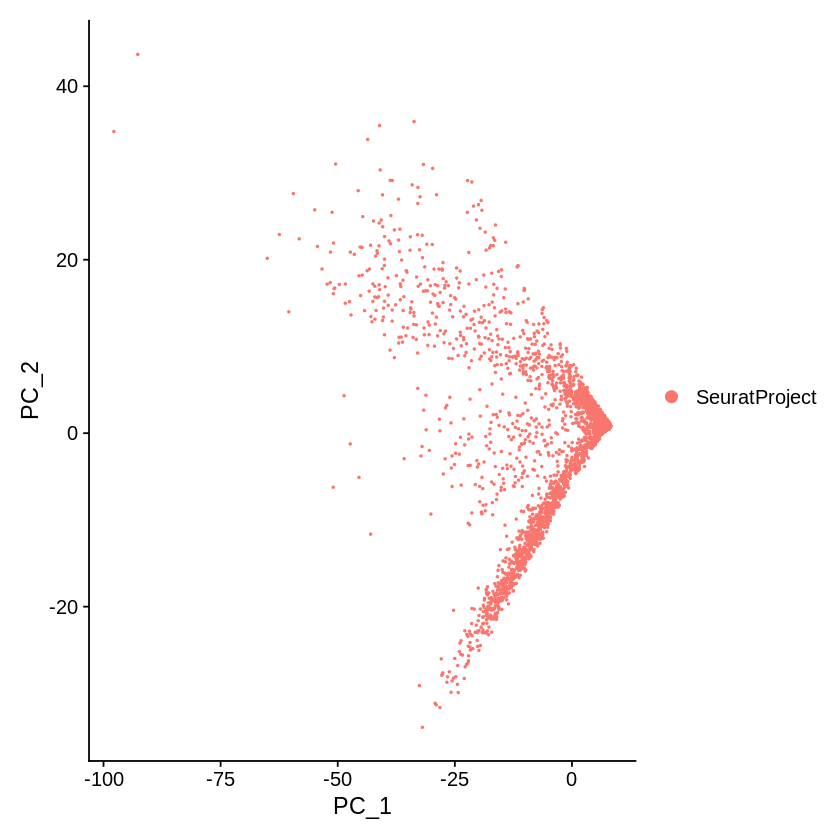

In [28]:
DimPlot(seurat_data,reduction="pca")

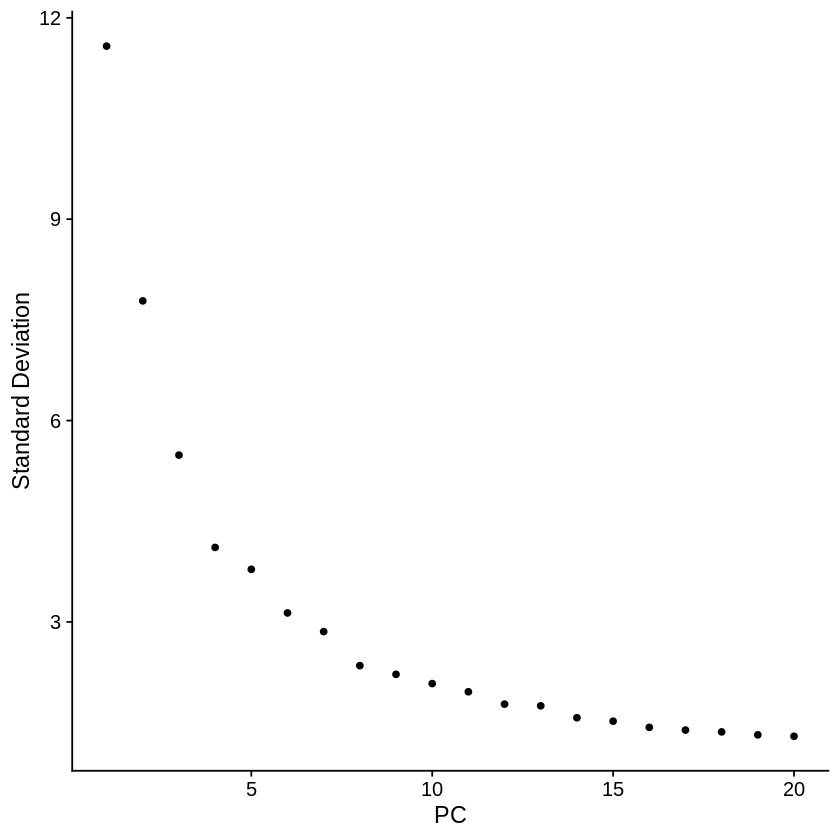

In [30]:
ElbowPlot(seurat_data)

## Format PCA table for MISTy

In [37]:
pca_table <- Embeddings(seurat_data, reduction = "pca")

In [69]:
# Filter cell barcodes to limit to region shared with Xenium
spots <- read.csv("data/spots.csv")$spot_name

In [184]:
pca_table <- data.frame(pca_table[row.names(pca_table) %in% spots,])

In [185]:
# Add spatial coordinates
coord = read.csv("data/spatial/tissue_positions.csv")

map_pos <- function(barcode){
    return(coord[coord$barcode == barcode, 
          c("pxl_row_in_fullres", "pxl_col_in_fullres")])
}

In [186]:
all_pos <- data.frame(t(sapply(rownames(pca_table), map_pos)))
colnames(all_pos) <- c("x", "y")
all_pos$x = as.numeric(all_pos$x)
all_pos$y = as.numeric(all_pos$y)

## Choosing a scale for the juxta and paraview

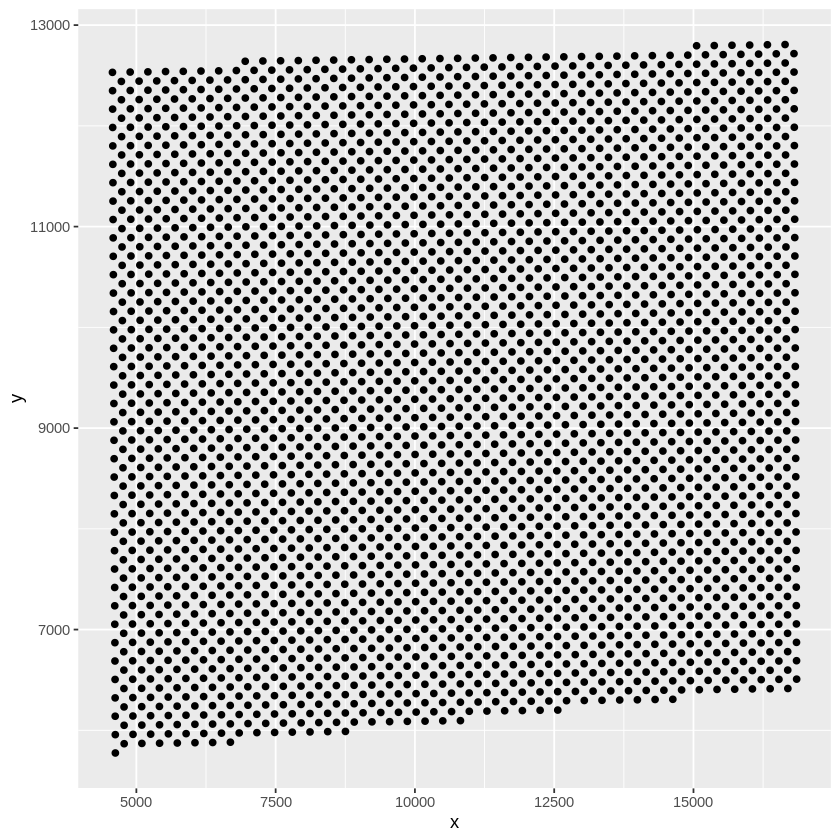

In [187]:
ggplot(all_pos, aes(x = x, y = y)) +
        geom_point()

In [188]:
all_pos[(all_pos$x < 5000)&(all_pos$y < 6000),]

x    y   
AACCAAGCGTGGCCTC-1 4623 5775
AAGCAGCCTACTAAGC-1 4940 5960
ATCATTCCACTTAGCA-1 4781 5867
CTAGATACAGACCGAG-1 4622 5957

In [189]:
sqrt((4622 - 4781)**2 + (5957 - 5867)**2)

[1] 182.7047

In [190]:
sqrt((4623 - 4622)**2 + (5957 - 5775)**2)

[1] 182.0027

In [191]:
table(dist(x = all_pos) < 183)


  FALSE    TRUE 
3997029    3177 

## MISTy
### Whole-slide MISTy

In [194]:
pca_table %>% 
    create_initial_view %>% 
    add_juxtaview(all_pos, neighbor.thr = 200) %>%
    add_paraview(all_pos, l = 600, zoi = 200) %>%
    run_misty(results.folder = "data/misty/")


Computing triangulation


Generating juxtaview


Generating paraview


Training models



[1] "/home/jovyan/data/misty"

In [196]:
misty.results <- collect_results("data/misty/")








Aggregating



Warning message:
“Removed 40 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 40 rows containing missing values (`geom_segment()`).”


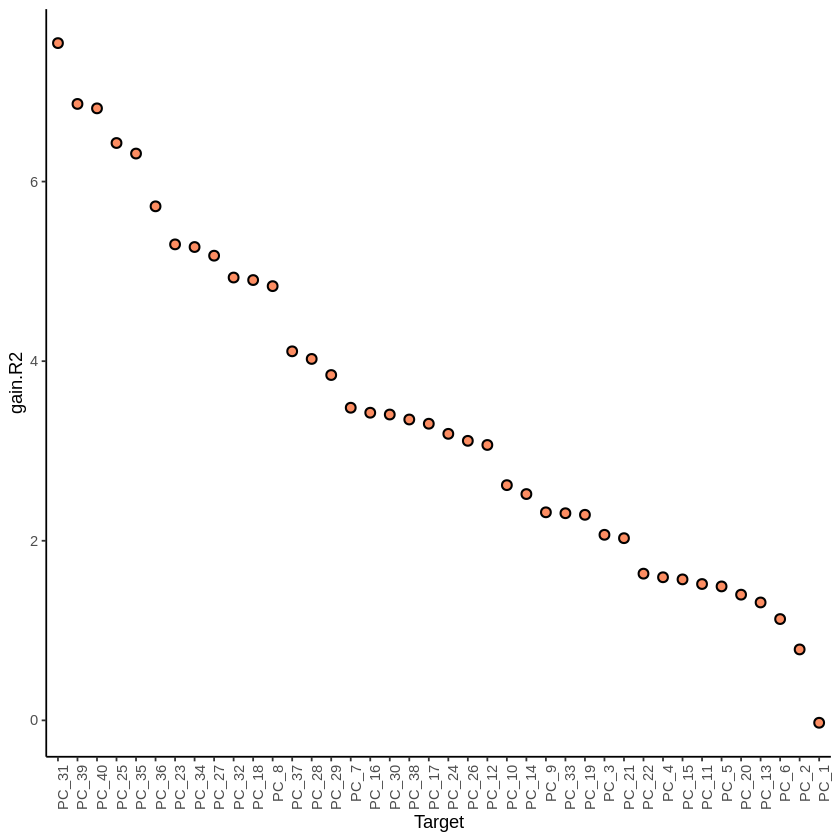

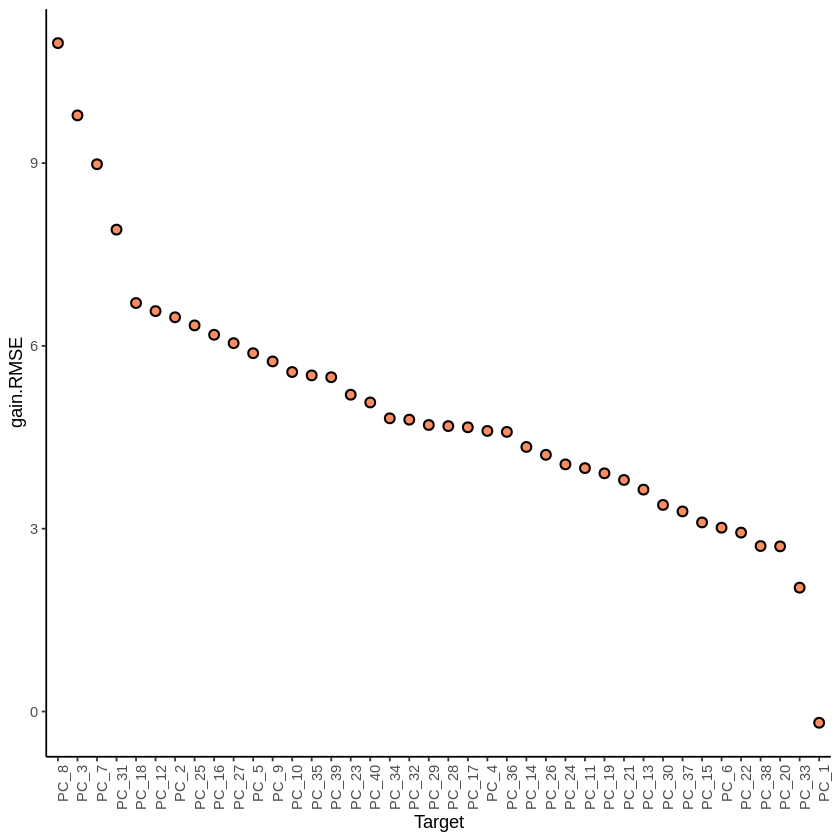

In [197]:
misty.results %>%
  plot_improvement_stats("gain.R2") %>%
  plot_improvement_stats("gain.RMSE")

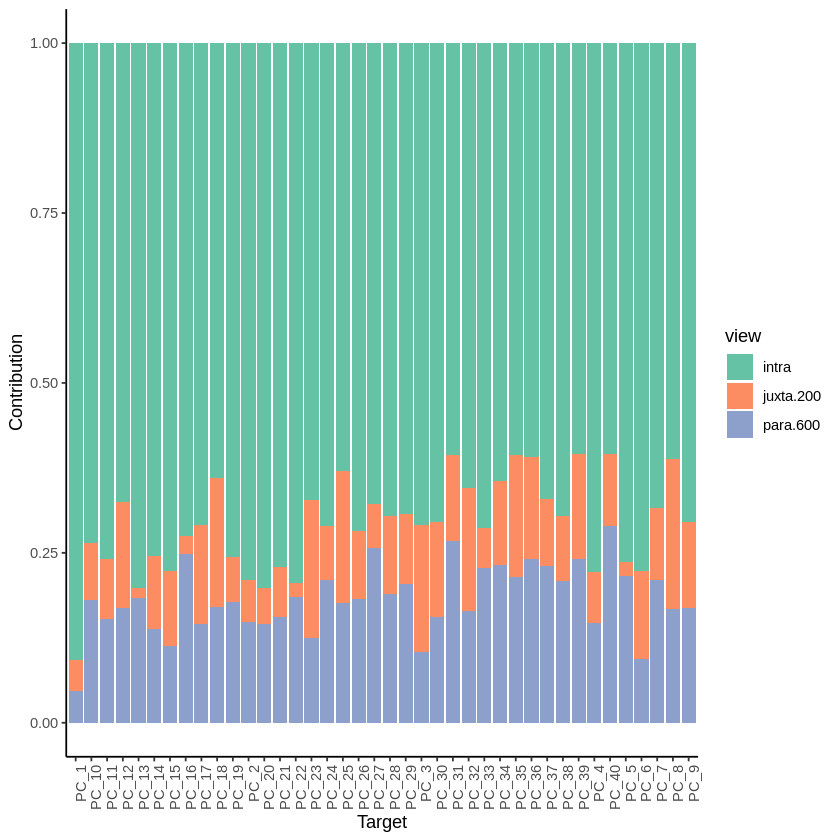

In [198]:
misty.results %>% plot_view_contributions()

### Sliding MISTy

In [101]:
# Try 10x10 spots per window, with half-window stride.